# Teoria da Decisão - Metodo + e -

*Alunos:*  

*Guilherme Fachinelli*

*Rafael Campello Soares*

*Stéphanie Barbosa*  

*Universidade Federal de Minas Gerais* 

In [1]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

class Struct:
    pass

def wrap_struct(solution):
    x = Struct()
    x.solution = solution
    return x


In [2]:
# Leitura dos dados
path_equip = 'Dados/EquipDB.csv'
path_planos = 'Dados/MPDB.csv'
path_cluster = 'Dados/ClusterDB.csv'

Equipamentos = pd.read_csv(path_equip, header=None, names=["ID", "t0", "cluster", "custo de falha"])
Planos = pd.read_csv(path_planos, header=None, names=["ID", "k", "custo"])
ModeloFalha = pd.read_csv(path_cluster, header=None, names=["ID", "eta", "beta"])

custo_por_plano = Planos.set_index("ID")["custo"].to_dict()

print("Equipamentos:")
print(Equipamentos.head(), "\n")
print("Planos de Manutenção:")
print(Planos.head(), "\n")
print("Modelos de Falha (Weibull):")
print(ModeloFalha.head())



Equipamentos:
   ID  t0  cluster  custo de falha
0   1   2        1               5
1   2   1        2              10
2   3   9        2               9
3   4   3        1               3
4   5   4        4               6 

Planos de Manutenção:
   ID    k  custo
0   1  2.0      0
1   2  1.5      1
2   3  1.0      2 

Modelos de Falha (Weibull):
   ID  eta  beta
0   1    8   1.0
1   2   11   1.1
2   3   13   1.3
3   4   16   1.5


In [3]:
#Solução inicial aleatoria

def Sol_Inicial(equipamentos):
    return np.random.randint(1, 4, size=len(equipamentos))

solucao_padrao = Sol_Inicial(Equipamentos)

print("Primeiros 10 planos atribuídos:", solucao_padrao[:10])
print("Distribuição dos planos:", dict(zip(*np.unique(solucao_padrao, return_counts=True))))


Primeiros 10 planos atribuídos: [2 1 2 3 3 3 2 1 2 2]
Distribuição dos planos: {np.int32(1): np.int64(160), np.int32(2): np.int64(176), np.int32(3): np.int64(164)}


In [4]:
def manutencao_def(equipamentos, planos):
    dados = Struct()
    dados.equipamentos = equipamentos
    dados.planos = planos.set_index("ID")
    dados.modelo_falha = ModeloFalha.set_index("ID")
    dados.n = len(equipamentos)
    dados.custo_por_plano = dados.planos["custo"].to_dict()
    return dados


In [5]:
def fobj_f1(x, dados):
    custo_total = sum(dados.custo_por_plano[plano] for plano in x.solution)
    x.fitness = custo_total
    return x

In [6]:
def fobj_f2(x, dados):
    custo = 0
    for i, plano in enumerate(x.solution):
        eq = dados.equipamentos.iloc[i]
        cluster = dados.modelo_falha.loc[eq["cluster"]]
        plano_info = dados.planos.loc[plano]

        t0 = eq["t0"]
        k = plano_info["k"]
        delta_t = 5
        eta = cluster["eta"]
        beta = cluster["beta"]

        Fi = lambda t: 1 - np.exp(-(t / eta)**beta)
        pi = (Fi(t0 + k * delta_t) - Fi(t0)) / (1 - Fi(t0))
        custo += pi * eq["custo de falha"]

    x.fitness = custo
    return x


In [7]:
'''
def soma_ponderada(i, j, fobj_f1, fobj_f2,):
    j = 100 - i
    return  (fobj_f1 * i) + fobj_f2 * j
    '''

'\ndef soma_ponderada(i, j, fobj_f1, fobj_f2,):\n    j = 100 - i\n    return  (fobj_f1 * i) + fobj_f2 * j\n    '

In [8]:
'''
Implementa a função neighborhoodChange
'''
def neighborhoodChange(x, y, k):
    if y.fitness < x.fitness:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
    return x, k


In [9]:
'''
Implementa a função shake
'''
def shake(x, r, planos=3):
    y = copy.deepcopy(x)
    indices = np.random.permutation(len(x.solution))[:r]
    for idx in indices:
        plano_atual = y.solution[idx]
        opcoes = [p for p in range(1, planos+1) if p != plano_atual]
        y.solution[idx] = np.random.choice(opcoes)
    return y

def shake_adiciona(x, r):
    y = copy.deepcopy(x)
    indices = np.random.permutation(len(y.solution))[:r]
    for idx in indices:
        if y.solution[idx] < 3:
            y.solution[idx] += 1
    return y


def shake_subtrai(x, r):
    y = copy.deepcopy(x)
    indices = np.random.permutation(len(y.solution))[:r]
    for idx in indices:
        if y.solution[idx] > 1:
            y.solution[idx] -= 1
    return y


### Estrutura principal do método RVNS

In [10]:
def rvns_otimizado(fobj, sol_inicial, shake, max_num_sol_avaliadas, r=10, kmax=3):
    x = wrap_struct(sol_inicial())
    x = fobj(x)
    
    num_sol_avaliadas = 1
    historico = []
    historico = [x.fitness]
    best = copy.deepcopy(x)
    historico_best = []
    historico_best = [best.fitness]

    estruturas_vizinhanca = [shake_adiciona, shake_subtrai, shake]

    while num_sol_avaliadas < max_num_sol_avaliadas:
        k = 1
        while k <= kmax and num_sol_avaliadas < max_num_sol_avaliadas:
            for shake_func in estruturas_vizinhanca:
                if num_sol_avaliadas >= max_num_sol_avaliadas:
                    break
                    
                y = shake_func(x, r)
                y = fobj(y)
                num_sol_avaliadas += 1
                historico.append(x.fitness)
                
                if y.fitness > best.fitness:
                    best = copy.deepcopy(y)
                historico_best.append(best.fitness)

                if y.fitness > x.fitness:
                    x = copy.deepcopy(y)
                    break
            else:
                k += 1

    print(f'\nTotal de soluções avaliadas: {num_sol_avaliadas}')
    # Impressão dos resultados
    print('\n--- SOLUÇÃO INICIAL CONSTRUÍDA ---\n')
    print('x = {}\n'.format(historico[0]))
    print('fitness(x) = {:.2f}\n'.format(historico[0]))

    print('\n--- MELHOR SOLUÇÃO ENCONTRADA ---\n')
    print('x = {}\n'.format(best.solution))
    print('fitness(x) = {:.2f}\n'.format(best.fitness))

  

    return best, historico



--- EXECUÇÃO PARA F1 - RVNS Otimizado ---

Executando a iteração 1...

Total de soluções avaliadas: 1000

--- SOLUÇÃO INICIAL CONSTRUÍDA ---

x = 519

fitness(x) = 519.00


--- MELHOR SOLUÇÃO ENCONTRADA ---

x = [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

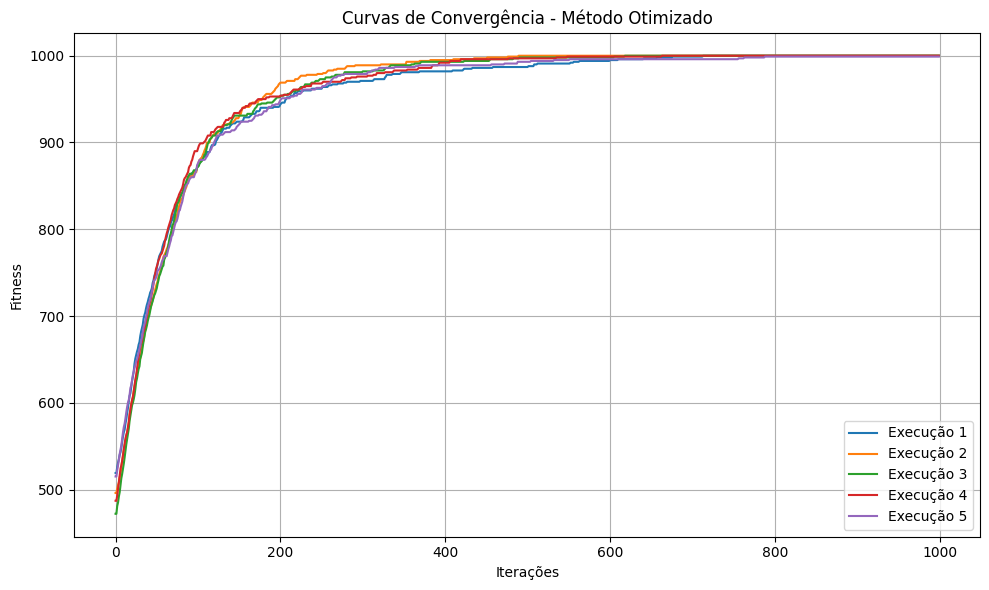


--- EXECUÇÃO PARA F2 - RVNS Otimizado ---

Executando a iteração 1...

Total de soluções avaliadas: 1000

--- SOLUÇÃO INICIAL CONSTRUÍDA ---

x = 1427.492304253442

fitness(x) = 1427.49


--- MELHOR SOLUÇÃO ENCONTRADA ---

x = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1

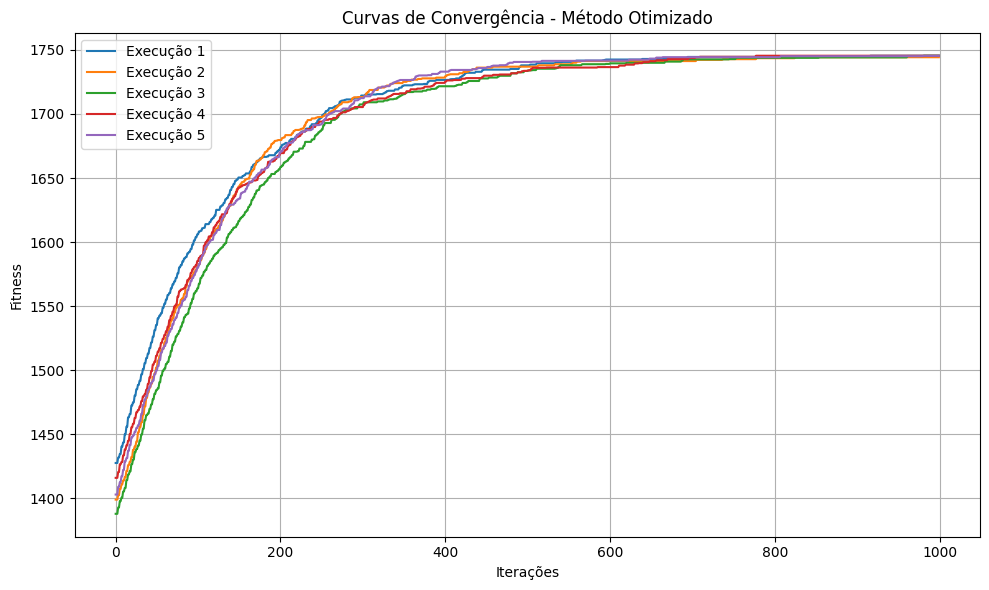

In [11]:
# Modificando a função de execução para receber métodos RVNS
def executar_otimizacao_multipla(fobj, sol_inicial, shake, max_num_sol_avaliadas=1000, kmax=3, num_execucoes=5, metodo="simples"):
    resultados = []
    historicos = []  # Lista para armazenar os históricos de cada execução
    
    for i in range(num_execucoes):
        print(f'Executando a iteração {i + 1}...')
        
        if metodo == "otimizado":
            best, historico = rvns_otimizado(
                fobj=fobj,
                sol_inicial=sol_inicial,
                shake=shake,
                max_num_sol_avaliadas=max_num_sol_avaliadas,
                r=10,
                kmax=kmax
            )
        
        resultados.append(best.fitness)
        historicos.append(historico)  # Armazena o histórico de fitness da execução
        
        print(f'Execução {i + 1} concluída, fitness: {best.fitness:.2f}')
    
    # Calcula as estatísticas (min, std e max)
    min_fitness = np.min(resultados)
    max_fitness = np.max(resultados)
    std_fitness = np.std(resultados)
    
    # Mostra as estatísticas finais
    print(f'\nEstatísticas após {num_execucoes} execuções:')
    print(f'Mínimo: {min_fitness:.2f}')
    print(f'Máximo: {max_fitness:.2f}')
    print(f'Desvio Padrão: {std_fitness:.2f}')
    
    # Plota as curvas de convergência para todas as execuções
    plt.figure(figsize=(10, 6))
    for i, historico in enumerate(historicos):  # Loop sobre os históricos de cada execução
        plt.plot(historico, label=f'Execução {i + 1}')
    
    plt.title(f"Curvas de Convergência - Método {metodo.capitalize()}")
    plt.xlabel("Iterações")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

dados = manutencao_def(Equipamentos, Planos)

# Execução para o método RVNS otimizado e F1
print('\n--- EXECUÇÃO PARA F1 - RVNS Otimizado ---\n')
executar_otimizacao_multipla(
    fobj=lambda x: fobj_f1(x, dados),
    sol_inicial=lambda: Sol_Inicial(Equipamentos),
    shake=shake,
    max_num_sol_avaliadas=1000,
    kmax=3,
    num_execucoes=5,
    metodo="otimizado"
)

# Execução para o método RVNS otimizado e F2
print('\n--- EXECUÇÃO PARA F2 - RVNS Otimizado ---\n')
executar_otimizacao_multipla(
    fobj=lambda x: fobj_f2(x, dados),
    sol_inicial=lambda: Sol_Inicial(Equipamentos),
    shake=shake,
    max_num_sol_avaliadas=1000,
    kmax=3,
    num_execucoes=5,
    metodo="otimizado"
)
